#                      STOCK MARKET PREDICTION

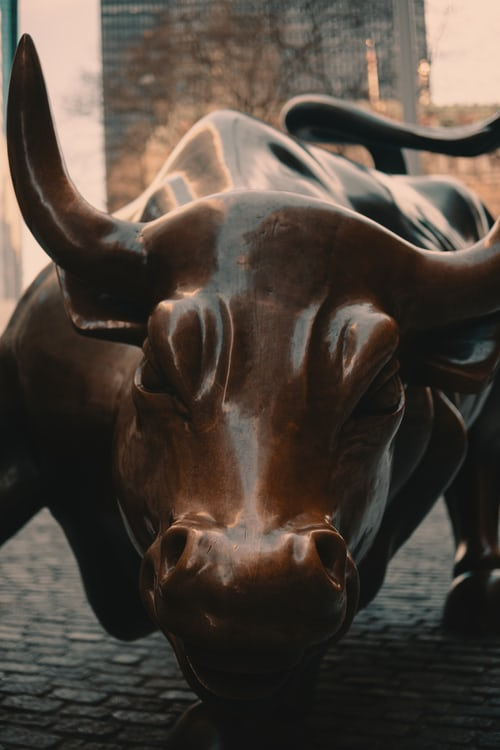

### Predicting stock prices using the power of Machine Learning has been a rapidly sought after research topics.
### Owing to the very nature of Stocks. The prediction depends on a **variety of factors**:
#### Market sentiments are one of such factors on which the price of stock largely depends.

### Market sentiments play a driving role in the pricing of the stock and the smart players are well aware of this boon in disguise. 

### In this notebook I have tried to model algorithms and hypertune their hyperparameters for predicting market sentiments which can then be used to price the stock in future with the maximum accuracy.



In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## getting our arsenal ready!!

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set()
%matplotlib notebook

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV

import nltk
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize, WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from collections import Counter 
from wordcloud import WordCloud
import re

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

## let us load the dataset

In [7]:
## loading the dataset
sentiment_dataset = pd.read_csv("stock_data.csv")

In [14]:
## loading the dataset
sentiment_dataset = pd.read_excel("3years_sent_score.xlsx")

## lets look at the data available

In [15]:
sentiment_dataset.head(5)

,Unnamed: 0,Date,title,Price,compound,neg,neu,pos,sent_score,blob_score,norm_score
0,0,20190101,Is it true that President Moon Jae in s remark...,0,0.9994,0.063,0.753,0.185,Neutral,0.114785,0.249859
1,1,20190102,Samsung Display s investment expansion good n...,0,1.0000,0.039,0.760,0.201,Positive,0.154085,0.250000
2,2,20190103,Editorial The KOSPI that collapsed in the ...,1,1.0000,0.031,0.794,0.175,Positive,0.134615,0.250000
3,3,20190104,Gangnam do billion won is too expensive Th...,1,0.9999,0.049,0.753,0.199,Positive,0.194742,0.249977
4,4,20190105,Photo BLACKPINK Jisoo Chic Eyes Golden D...,0,0.8225,0.016,0.858,0.126,Negative,0.137807,0.207736


#### so the first column contains the news and second has the sentiment


In [16]:
sentiment_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1096 non-null   int64  
 1   Date        1096 non-null   int64  
 2   title       1096 non-null   object 
 3   Price       1096 non-null   int64  
 4   compound    1096 non-null   float64
 5   neg         1096 non-null   float64
 6   neu         1096 non-null   float64
 7   pos         1096 non-null   float64
 8   sent_score  1096 non-null   object 
 9   blob_score  1096 non-null   float64
 10  norm_score  1096 non-null   float64
dtypes: float64(6), int64(3), object(2)
memory usage: 94.3+ KB


In [17]:
## percentage of positive and negative sentiments
(sentiment_dataset["sent_score"].value_counts()/len(sentiment_dataset)) * 100

Neutral     43.704380
Positive    30.565693
Negative    25.729927
Name: sent_score, dtype: float64

#### Ohho!! we have a fair large number of data points 5791 in total
#### with a 7:4 taget values (which is good)

<IPython.core.display.Javascript object>


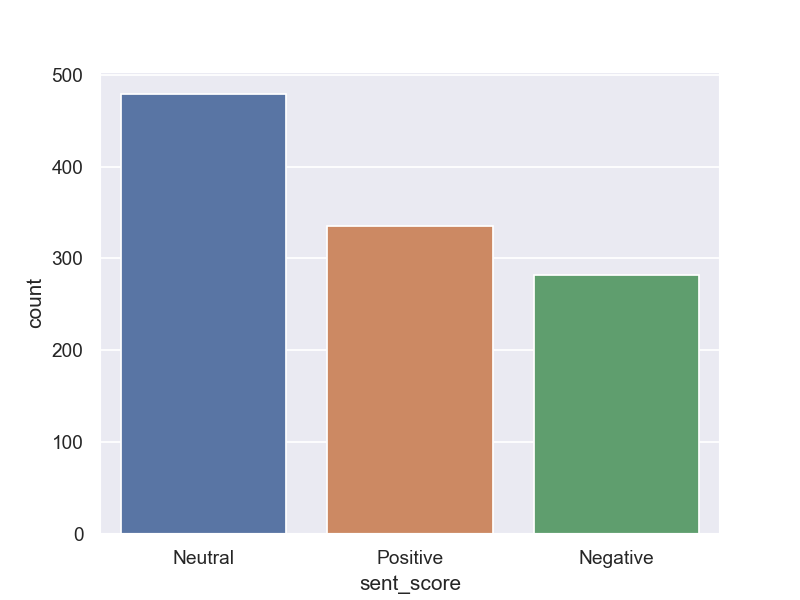

<AxesSubplot:xlabel='sent_score', ylabel='count'>

In [18]:
## Plot the Sentiment value count 
sns.countplot(x=sentiment_dataset["sent_score"] )

#### the above plot shows fair number of news inclined in positive but the imbalance in not that much

## Checking for stopwords

In [19]:
stop_words=set(stopwords.words("english"))

In [23]:
word_list = list()
for i in range(len(sentiment_dataset)):
    words = sentiment_dataset.title[i].split()
    for j in words:
        word_list.append(j)

In [24]:
wordCounter = Counter(word_list)
countedWordDict = dict(wordCounter)
sortedWordDict = sorted(countedWordDict.items(),key = lambda x : x[1],reverse=True)
sortedWordDict[0:20]

[('the', 77196),
 ('of', 58453),
 ('in', 45293),
 ('to', 37259),
 ('term', 28228),
 ('a', 26780),
 ('and', 24528),
 ('s', 24380),
 ('for', 23301),
 ('than', 21331),
 ('more', 19608),
 ('moving', 17705),
 ('won', 16203),
 ('price', 16022),
 ('is', 15118),
 ('average', 14551),
 ('year', 13526),
 ('on', 13293),
 ('short', 13133),
 ('stock', 13129)]

#### these are the stop words present in the news text

In [25]:
# stop_word_Cloud = set(stopwords.words("english"))
# wordcloud = WordCloud(stopwords=stop_word_Cloud,max_words=2000,background_color="black",min_font_size=5).generate_from_frequencies(countedWordDict)
# plt.figure(figsize=[10,5])
# plt.axis("off")
# plt.imshow(wordcloud)
# plt.show()

<IPython.core.display.Javascript object>


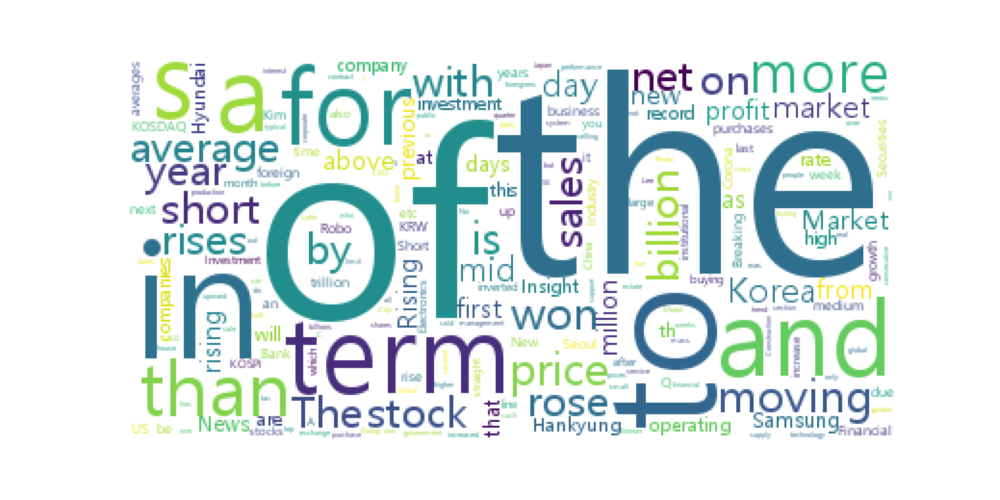

In [27]:
# 워드클라우드를 그려보자

wordcloud = WordCloud(font_path='c:/Windows/Fonts/malgun.ttf',
                     relative_scaling=0.2,
                     background_color='white').generate_from_frequencies(dict(countedWordDict))

plt.figure(figsize=(8,4))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


## Data Preprocessing

#### Replacing the negative one with zero so our model can predict well

In [12]:
sentiment_dataset["sent_score"] = sentiment_dataset["sent_score"].replace(-1,0)

#### NLP Processing

In [13]:
ps = PorterStemmer()
lemma = WordNetLemmatizer()
stopwordSet = set(stopwords.words("english"))

#### cleaning the text

In [14]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ym\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [15]:
text_reviews = list()
for i in range(len(sentiment_dataset)):
    text = re.sub('[^a-zA-Z]'," ",sentiment_dataset['title'][i])
    text = text.lower()
    text = word_tokenize(text,language="english")
    text = [lemma.lemmatize(word) for word in text if(word) not in stopwordSet]
    text = " ".join(text)
    text_reviews.append(text)

#### creating the Bag of Word model

In [16]:
cv = CountVectorizer(max_features = 1500)
X = cv.fit_transform(text_reviews).toarray()
Y= sentiment_dataset['sent_score']

## Split the dataset into Training and Test set
X_train, X_test, y_train, y_test = train_test_split(X, Y , test_size=0.25, random_state = 1)

## Modelling

### 1. Logistic Regression

In [17]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
Y_pred = logreg.predict(X_test)

C:\Users\ym\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [18]:
print("logistic regression\n")
print("confusion matrix:\n {}".format(confusion_matrix(y_test, Y_pred)))
print("\n\naccuracy: {}".format(accuracy_score(y_test, Y_pred)))

logistic regression

confusion matrix:
 [[65 12  1]
 [11 67 35]
 [ 0 24 59]]


accuracy: 0.6970802919708029


#### the model gave an accuracy of 76.79%. Let's see if it can be increased by hypertuning

## hyperparameter tuning for logistic regression

In [19]:
logreg = LogisticRegression()

#listing hyperparameters
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=logreg, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)


# summarize results
print("Best accuracy: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


Best accuracy: 0.800411 using {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}


### 2. Random Forest

In [20]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)
Y_pred = random_forest.predict(X_test)

In [21]:
print("Random Forest\n")
print("confusion matrix:\n {}".format(confusion_matrix(y_test, Y_pred)))
print("\n\naccuracy: {}".format(accuracy_score(y_test, Y_pred)))

Random Forest

confusion matrix:
 [[61 17  0]
 [ 6 91 16]
 [ 0 32 51]]


accuracy: 0.7408759124087592


## hyperparameter tuning for random forest classifier

In [22]:
random_forest = RandomForestClassifier()

#listing hyperparameters
n_estimators = [10, 100, 1000]
max_features = ['sqrt', 'log2']

# defining grid search
grid = dict(n_estimators=n_estimators,max_features=max_features)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=random_forest, param_grid=grid, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)


# summarizing results
print("Best accuracy: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


Best accuracy: 0.771212 using {'max_features': 'sqrt', 'n_estimators': 1000}


dataset link: [stockmarket-sentiment-dataset](https://www.kaggle.com/yash612/stockmarket-sentiment-dataset)

ensemble methods can increase the accuracy by a notable amount. 